In [1]:
#pip install control

In [3]:
import control

In [4]:
s = control.tf('s')

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [66]:
df = pd.read_excel('Experimento 1.xlsx')

In [67]:
df.describe()

,Time,PV,MV
count,791,791.000000,791.000000
mean,2017-11-10 09:13:24.635000320,27.065360,48.293300
min,2017-11-10 09:06:49.635000,24.200000,0.000000
25%,2017-11-10 09:10:07.135000064,26.100000,50.000000
50%,2017-11-10 09:13:24.635000064,27.600000,50.000000
75%,2017-11-10 09:16:42.135000064,28.200000,50.000000
max,2017-11-10 09:19:59.635000,28.600000,50.000000
std,NaN,1.351198,9.084411


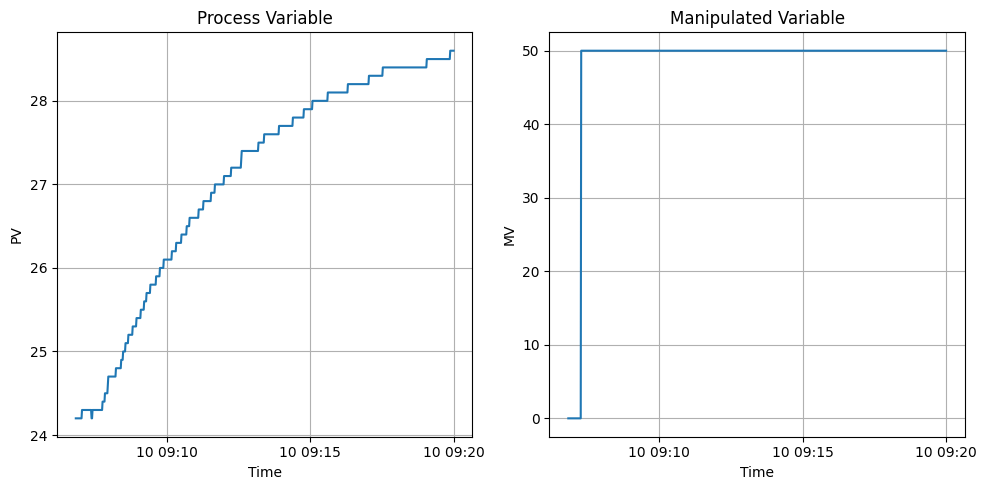

In [68]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot Data
axes[0].plot(df['Time'],df['PV'])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('PV')
axes[0].set_title('Process Variable')
axes[0].grid()

# Plot Data
axes[1].plot(df['Time'],df['MV'])
axes[1].set_xlabel('Time')
axes[1].set_ylabel('MV')
axes[1].set_title('Manipulated Variable')
axes[1].grid()

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()


In [69]:
valores = df['MV'].values
tempo = df['Time'].values

# Encontrar o índice onde ocorre a mudança de valor
indice_degrau = np.where(np.diff(valores) != 0)[0][0]

# Valor de tempo onde ocorre o degrau
tempo_degrau = tempo[indice_degrau + 1]

print("O degrau ocorre em t =", tempo_degrau)

O degrau ocorre em t = 2017-11-10T09:07:16.635000000


In [70]:
indice_degrau

26

In [71]:
df = df.drop(df.index[:indice_degrau+1])

In [72]:
df

,Time,PV,MV
27,2017-11-10 09:07:16.635,24.3,50
28,2017-11-10 09:07:17.635,24.3,50
29,2017-11-10 09:07:18.635,24.3,50
30,2017-11-10 09:07:19.635,24.3,50
31,2017-11-10 09:07:20.635,24.3,50
...,...,...,...
786,2017-11-10 09:19:55.635,28.6,50
787,2017-11-10 09:19:56.635,28.6,50
788,2017-11-10 09:19:57.635,28.6,50
789,2017-11-10 09:19:58.635,28.6,50


In [73]:
# Obter o valor do primeiro tempo
primeiro_tempo = df['Time'].iloc[0]

# Ajustar os valores da coluna 'tempo'
df['Time'] = df['Time'] - primeiro_tempo

In [74]:
df

,Time,PV,MV
27,0 days 00:00:00,24.3,50
28,0 days 00:00:01,24.3,50
29,0 days 00:00:02,24.3,50
30,0 days 00:00:03,24.3,50
31,0 days 00:00:04,24.3,50
...,...,...,...
786,0 days 00:12:39,28.6,50
787,0 days 00:12:40,28.6,50
788,0 days 00:12:41,28.6,50
789,0 days 00:12:42,28.6,50


In [75]:
Delta_t = df['Time'].iloc[1] - df['Time'].iloc[0]

In [76]:
Delta_t

Timedelta('0 days 00:00:01')

In [89]:
Max_t = df['Time'].max()
Max_t

Timedelta('0 days 00:12:43')

In [90]:
Count_t = len(df['Time'])
Count_t

764

## Optimize

In [80]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [96]:
def fun(x):
    global df
    
    Kp = x[0]
    Tau = x[1]
    Delay = x[2]
    
    sys  = Kp/(Tau*s + 1)
    
    num, den = control.pade(Delay, n=2, numdeg=0)
    Pade = control.tf(num, den)
    
    FOPDT = control.series(sys, Pade)
    
    # Simulate step response
    t_fun, y_fun = control.step_response(FOPDT, T=764, T_num=Count_t)
    df_fun = pd.DataFrame({'t_fun':t_fun, 'y_fun':y_fun})
    
    mse = mean_squared_error(df_fun['y_fun'], df['PV'])
    return mse

In [102]:
Chute_Kp = max(df['PV'])
Chute_Tau =  764/5
Chute_Delay = Chute_Tau/10

In [103]:
x0 = [Chute_Kp, Chute_Tau, Chute_Delay]
x0

[28.6, 152.8, 15.280000000000001]

In [106]:
bnds = ((0, None), (0, None), (1e-5, None))

In [107]:
res = minimize(fun, x0, method='Powell', bounds=bnds, tol=1e-6)

ValueError: require T >= 0

In [ ]:
Kp_opt = res.x[0]
Tau_opt = res.x[1]
Delay_opt = res.x[2]

sys  = Kp_opt/(Tau_opt*s + 1)

num, den = control.pade(Delay_opt, n=2, numdeg=0)
Pade = control.tf(num, den)
    
sys_opt = control.series(sys, Pade)

In [ ]:
print('Kp=', Kp_opt)
print('Tau=', Tau_opt)
print('Delay=', Delay_opt)

## Plots

In [ ]:
t_opt, y_opt = control.step_response(sys_opt, T=Max_t, T_num=Count_t)

In [ ]:
# Plot step response
plt.plot(t_opt,y_opt)
plt.scatter(df['t'], df['y'], marker= ".", color = "red")
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('System Step Response')
plt.grid()
plt.show()